<a href="https://colab.research.google.com/github/torifinch/TimeSeriesAnalysis/blob/main/GroceryStore_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing Data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Unzip the downloaded dataset
!unzip /content/drive/MyDrive/retail_kaggle_data/favorita-grocery-sales-forecasting.zip

Archive:  /content/drive/MyDrive/retail_kaggle_data/favorita-grocery-sales-forecasting.zip
  inflating: holidays_events.csv.7z  
  inflating: items.csv.7z            
  inflating: oil.csv.7z              
  inflating: sample_submission.csv.7z  
  inflating: stores.csv.7z           
  inflating: test.csv.7z             
  inflating: train.csv.7z            
  inflating: transactions.csv.7z     


In [10]:
!apt-get install -y p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [11]:
# Extract the files
!7z e train.csv.7z
!7z e stores.csv.7z
!7z e items.csv.7z
!7z e holidays_events.csv.7z
!7z e oil.csv.7z
!7z e transactions.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 474092593 bytes (453 MiB)

Extracting archive: train.csv.7z
--
Path = train.csv.7z
Type = 7z
Physical Size = 474092593
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train.csv                  1% - train.csv                  2% - train.csv                  3% - train.csv                  4% - train.csv                  5% - train.csv                  6% - train.csv                  7% - train.csv                  8% - train.csv

#EDA for Time-series data

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [13]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('stores.csv')
df_items = pd.read_csv('items.csv')
df_transactions = pd.read_csv('transactions.csv')
df_oil = pd.read_csv('oil.csv')
df_holidays_events = pd.read_csv('holidays_events.csv')

# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('train.csv', nrows=2e6)

In [14]:
df_items.head(5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


## Filtering by Region
Selecting only data for “Guayas” region to further filter our data

In [33]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-33-b3ad23cc94c1>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('train.csv', chunksize=chunk_size):


In [34]:
# Filter for only January-March 2014, including March
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train[(df_train['date'] >= '2014-01-01') & (df_train['date'] <= '2014-3-31')]


Selecting only Top 3 families by the number of items

In [35]:
# Get the top-3 families by the number of items
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # here is where we get the top-3 families

item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

# As a result, you'll have the df_train that only has items from the top 3 families

In [41]:
top_3_families.head()

,Family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


In [42]:
# Loads first 5 rows
df_train.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
2984224,16323658,2014-01-01,36,96995,1.0,NaN
2984226,16323660,2014-01-01,36,105576,4.0,NaN
2984227,16323661,2014-01-01,36,105693,1.0,NaN
2984228,16323662,2014-01-01,36,106716,3.0,NaN
2984231,16323665,2014-01-01,36,108786,1.0,NaN


##Checking for Missing Data

In [18]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


In [19]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

<ipython-input-19-7bdead4240c5>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


##Handling Outliers

In [20]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
44564564,101697169,2017-01-02,3,2006144,-1.0,False
44597235,101787141,2017-01-02,47,250782,-1.0,False
44607380,101806321,2017-01-03,1,1464177,-1.0,False
44608744,101807685,2017-01-03,2,819194,-1.0,False
44611802,101810743,2017-01-03,3,1228300,-2.0,False


A Z-score (or standard score) is a statistical measurement that describes how many standard deviations a data point is from the mean of the dataset. It is a way to standardize data and make it comparable by converting different values to a common scale. Z-scores are often used to detect outliers and understand the relative position of a data point within a distribution.

In [21]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 19371


<ipython-input-21-19d44cdb3f57>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
66,119501915,2017-06-20,1,99197,13.0,False,6.350687
136,110497813,2017-03-27,1,103520,13.0,False,5.193985
696,108409826,2017-03-07,1,105575,38.0,False,5.061340
1050,104932608,2017-02-02,1,105737,20.0,False,6.176835
1739,120761109,2017-07-02,1,108634,5.0,False,5.336142


Outliers should be checked to rsee if there is a logical reason behind them

##Fill missing dates with zero sales

In [22]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})

# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')

# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
df_filled.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,1,103520,2017-01-02,101690472.0,1.0,False
1,1,103520,2017-01-03,101804698.0,2.0,False
2,1,103520,2017-01-04,NaN,0.0,NaN
3,1,103520,2017-01-05,102021352.0,2.0,False
4,1,103520,2017-01-06,102123567.0,3.0,False


## Feature Engineering

In [23]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

##Smoothing
Using 7 mean smoothed because the data is by day and we want a week at a time.

In [24]:
# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

##Visualizing Time-Series Data

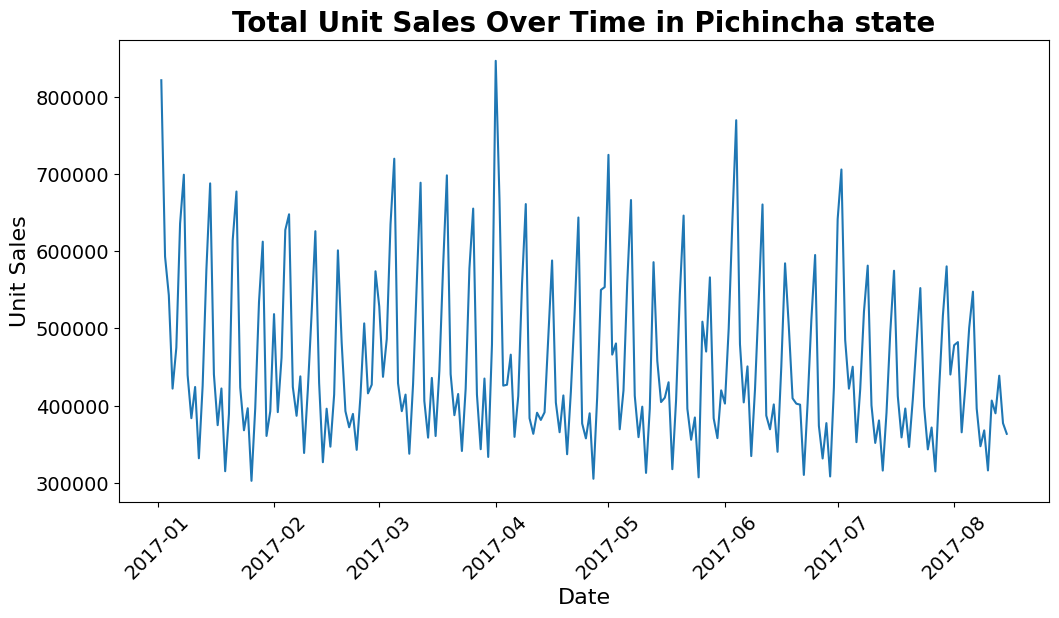

In [25]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Pichincha state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [26]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

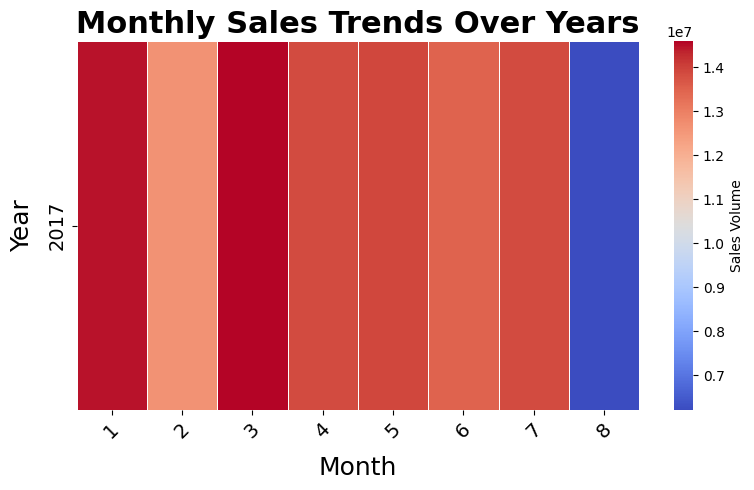

In [27]:
# Plotting heatmap of sales by year and month
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

##Examining the Impact of Holidays


In [28]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

Holidays range: from 2012-03-02 till 2017-12-26


In [29]:
# Merging df_train data with holidays
df_train_holiday = pd.merge(df_train, df_holidays_events, on='date', how='left')

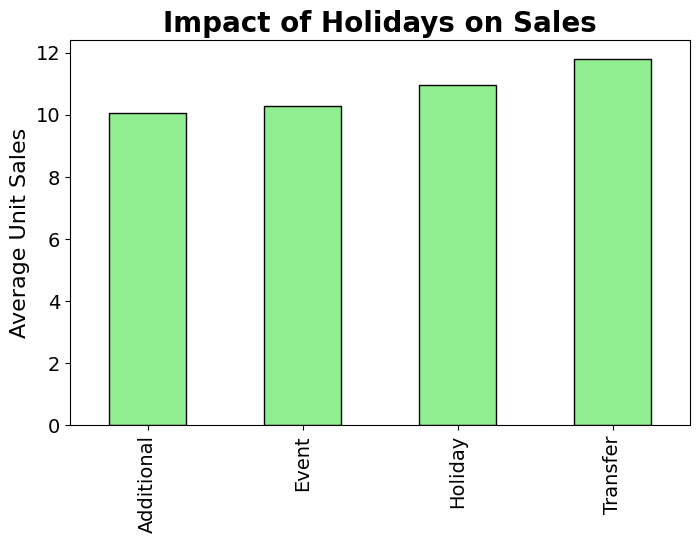

In [30]:
# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

##Analyzing Perishable Items


In [31]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)

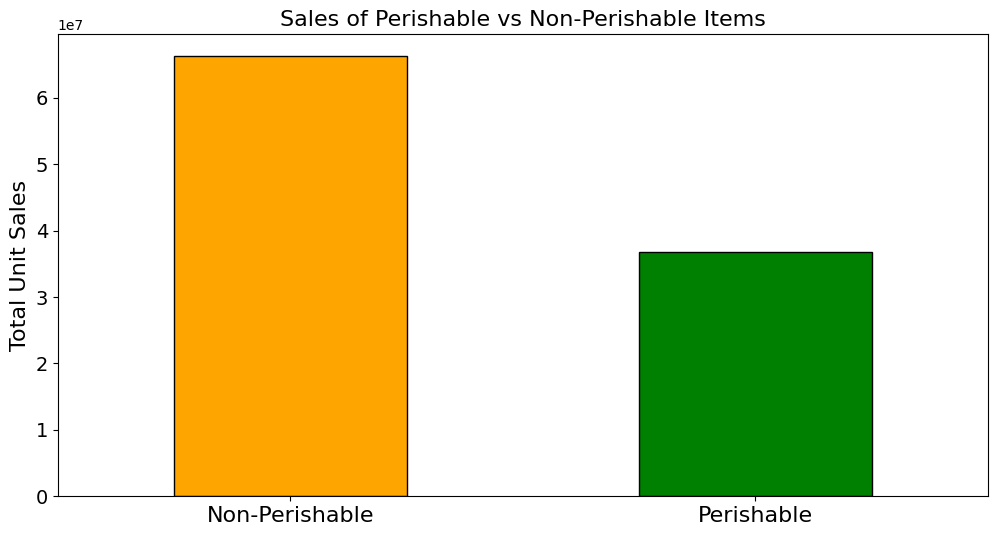

In [32]:
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

#Key Takeaways
📌
Handle missing data and outliers in time-series data carefully.

📌
Visualizations help identify trends, seasonality, and anomalies.

📌
Feature engineering, such as extracting date components and rolling averages, is crucial for time-series forecasting.

📌
External factors, like oil prices and holidays, significantly impact sales and should be incorporated into modeling.

Data Exploration (it should be done in a similar manner we did in the sprint lessons):
- Find out if there are any missing values and eliminate them. As for the missing dates, fill them up with zero sales.
- Handle outliers in unit_sales if there are any.
- Engineer features similar to what we did in the in this theory of this sprint
- Save the prepared dataset as a .csv file to your google drive. During the next weeks, will get back to this data!
EDA for the region of our interest ("Guayas")
- Conduct an exploratory data analysis (EDA). Find out the answers for the questions that are similar to what found answers for the "Pichincha" region but now for the "Guayas" region.
- Feel free to examine the data even further! It would enrich your project and lead you to better data understanding.